## Setup

In [12]:
from IPython import get_ipython
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

import os;

os.environ["ACCELERATE_ENABLE_RICH"] = "0"

os.environ['WANDB_NOTEBOOK_NAME'] = os.path.basename(globals()['__vsc_ipynb_file__']) 

# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


import sys
from functools import partial
import json
from typing import List, Tuple, Union, Optional, Callable, Dict
import torch as t
from torch import Tensor
from sklearn.linear_model import LinearRegression
import numpy as np
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import einops
from tqdm import tqdm
from jaxtyping import Float, Int, Bool
from pathlib import Path
import pandas as pd
import circuitsvis as cv
import webbrowser
from IPython.display import display
from transformer_lens import utils, ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint
from transformer_lens.components import LayerNorm
from eindex import eindex

import functools
import matplotlib.pyplot as plt

# t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "monthly_algorithmic_problems" / "september23_sum"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from monthly_algorithmic_problems.september23_sum.model import create_model
from monthly_algorithmic_problems.september23_sum.training import train, TrainArgs
from monthly_algorithmic_problems.september23_sum.dataset import SumDataset,Pairs
from plotly_utils import hist, bar, imshow

# Running this on a macbook air and mps is flaky
device = t.device("cpu") #t.device("cuda" if t.cuda.is_available() else "cpu")


MAIN = __name__ == "__main__"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

-- Note: I rewrote the Dataset class so that it balances no carry, plain carry and cascading carry  classes evenly. this puts a larger emphasis difficult cases relative to the original way this dataset was written. With random additions, cascading carry is an edge case that is quite infrequent. 

-- I added a "START" token under the premise that it functions as an attention sink https://arxiv.org/pdf/2309.17453.pdf
In truth, I really need to do more experiments to justify this. 

In [13]:
dataset = SumDataset(size=1000, num_digits=4).to(device)

## Transformer

-- After doing this excercise, I also wanted to modify the attention mask because as you can see below, the loss function is only being calculated on the last num_digits. 

    def _shared_train_validation_step(self, toks: Tensor) -> Tuple[Tensor, Tensor]:
        toks = toks.to(self.args.device)
        logits = self.model(toks)[:, -(self.args.num_digits+1):-1]
        target = toks[:, -self.args.num_digits:]
        return logits, target

-- FYI: I removed the weight_decay while I was playing around with adding a different form of regularization (minimizing the loss as a sum of covariance between activations of attention heads). I'm not including results from these tests at this point as there was a bit more work to do on it before I could make sense of the results. 

In [14]:
filename = section_dir / "sum_model_normal.pt" # note this was trained on a mac in cpu mode without cuda and mps
args = TrainArgs(
    num_digits=4,
    trainset_size=100_000,
    valset_size=5_000,
    epochs=100,
    batch_size=512,
    lr_start=2e-3,
    lr_end=1e-4,
    # weight_decay=0.001, # not weight decay, could add this back in 
    weight_decay=0.00,
    seed=42,
    d_model=48,
    d_head=24,
    n_layers=2,
    n_heads=3,
    d_mlp=None,
    normalization_type="LN",
    use_wandb=True,
    device=device,
    # corr_loss=CorrLoss(rank=2) # add this to add in a loss function of rank=2 for the correlation between activations on different attention heads
)
model = create_model(
    num_digits=4,
    seed=0,
    d_model=48,
    d_head=24,
    n_layers=2,
    n_heads=3,
    normalization_type="LN",
    d_mlp=None,
    device=device
)
model.load_state_dict(t.load(filename))

# model = train(args)
# t.save(model.state_dict(), filename)

<All keys matched successfully>

#### ** <i>Experiment</i> **

-- This was an attempt to see if I could get heads to function independently by driving them to act on different principle components. The code works, but I'm still thinking about the results. It was an experiment, but not (as of yet) a completed one

-- This loss function gets added in as a hook in training.py


In [15]:
import torch as t
import torch.nn as nn
import itertools
import math

class CorrLoss(nn.Module):
    def __init__(self, rank=None):
        super(CorrLoss, self).__init__()
        self.rank = rank  # Rank for truncated SVD
        self.loss = 0

    def _result_hook(self,result: Float[Tensor, "batch seq head_idx d_model"],hook: HookPoint,layer: int) -> Float[Tensor, "batch seq head_idx d_model"]:
        # result is [batch, seq, heads, d_model]
        self.loss = self.loss + self.forward(result)
        # this works - print( f"result_hook layer {layer} ", result.shape )
        return result
    
    def get_loss(self):
        loss      = self.loss
        self.loss = 0
        return loss

    def result_hook(self, layer ) :
        return functools.partial(self._result_hook,layer=layer)

    def forward(self, activations):        
        # activations is [batch, seq, heads, d_model]
        assert activations.dim() == 4, "activations must be [batch, seq, heads, d_model]"

        # flatten the list of lists of matrices ( seq * rank matrices )
        m_list = list(itertools.chain.from_iterable(self.all_tensors(activations)))

        loss = t.stack( m_list ).abs().sum()
 
        # loss += self.corr( activations.reshape( -1 , activations.shape[-1] ) ).abs().sum()

        return loss
        
    # the idea here is that we are trying to get the heads to work on different principle components. 
    # Instead of computing different correlation matrices for all 48 dimensions, let's reduce the dimensionality
    # to a smaller number of principle components and then compute the correlation matrix on those.    
    # returned data is [batch, head_idx, rank]
    def feature_reduction(self, data):
        #  data is [batch, seq=1, heads , d_model]
        assert data.dim() == 3, "data must be [batch, heads, d_model] (e.g. sliced by seq)"

        reshaped_data = data.reshape( data.shape[0]*data.shape[1], data.shape[2])

        assert reshaped_data.dim() == 2, "data must be [batch*heads, d_model ]"

        U, S, V = t.svd_lowrank(reshaped_data, q=self.rank)

        principal_components = V[:, :self.rank].t()  

        reduced_data = t.einsum('bhd,rd->bhr', data , principal_components)  # Reduced data has shape [batch, heads, rank]

        assert reduced_data.dim() == 3 and reduced_data.size(-1) == self.rank, "data must be [batch, heads, rank]"

        return  reduced_data

    
    # returns a list of matrices for every feature e.g. [ [head,head], [head,head], ... ]
    # call with a tensor sliced by seq
    def feature_tensor(self, data):

        assert data.dim() == 3, "data must be [batch, heads, d_model] (e.g. sliced by seq)"

        if self.rank is not None and self.rank <= data.shape[-1]:
            data = self.feature_reduction(data)

        assert data.dim() == 3, "data must be [batch, heads, rank ] (e.g. sliced by seq, d_model reduced to rank)"

        return [ self.corr(data[:,:,rank]) for rank in range(data.shape[-1]) ]

    # returns a matrix [heads, heads]
    def corr(self, data):

        assert data.dim() == 2, "data must be [batch, heads]"

        epsilon = 1e-8
        mean = t.mean(data, dim=0, keepdim=True)
        demeaned_data = data - mean
        covariance = t.mm(demeaned_data.T, demeaned_data) / (data.shape[0] - 1)
        std_dev = t.sqrt(t.diag(covariance) + epsilon).unsqueeze(1)
        correlation = covariance / (std_dev @ std_dev.T)
        correlation -= t.eye(correlation.size(0),device=device) * t.diag(correlation)
        # correlation is [heads, heads]
        return correlation

    # returns a list for every seq [ [ [head,head], [head,head], ... ], [ [head,head], [head,head], ... ], ... ]
    def all_tensors(self, activations):
        return [ self.feature_tensor(activations[:,seq]) for seq in range(activations.shape[1]) ]


    # makes some pretty pictures so you can watch the correlations be reduced. 
    def plot_tensors(self, activations , layer=0 , epoch=0, fill_diagonal=False):

        assert activations.dim() == 4, "activations must be [batch, seq, heads, d_model]"

        vocab       = ["ST","0","1","2","3","+","4","5","6","7","=","-4","-3","-2","-1"]

        data = self.all_tensors(activations)
        cols = len(data)
        rows = len(data[0])

        fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows), sharex=True, sharey=True)
        fig.subplots_adjust(wspace=0.05, hspace=0.05)
        fig.suptitle(f'Head Output Correlation Matrices for Layer {layer}', fontsize=24)

        for i, ax in enumerate(axes.flat):
            r = i // cols
            c = i % cols

            d = data[c][r].detach().cpu().numpy()
            if fill_diagonal:
                np.fill_diagonal(d, 1)

            im = ax.imshow(d, cmap='bwr', aspect='equal', vmin=-1, vmax=1)
            if i % cols == 0:
                ax.set_yticks(range(d.shape[0]))
                ax.set_yticklabels([ f"H {str(h)}" for h in range(d.shape[0]) ])
                ax.set_ylabel( f"PC{str(r+1)}", labelpad=10,size=16)
            else:
                ax.set_yticks([])
                
            if i // cols == rows - 1:
                ax.set_xticks(range(d.shape[1]))
                ax.set_xticklabels([ f"{str(h)}" for h in range(d.shape[0]) ])
                ax.set_xlabel(vocab[c], labelpad=10,size=16)
            else:
                ax.set_xticks([])
            
        # Create a single colorbar
        cbar = plt.colorbar(im, ax=axes, orientation='vertical', fraction=0.2, pad=0.07, shrink=.8 , aspect=15, format='%d', ticks=[-1, 0, 1])
        cbar.set_label('Correlation', rotation=90, size=16)
        cbar.ax.tick_params(labelsize=8)
        plt.show()

# This is the dataset I'll use for the experiments below. 
- 1000 examples
- Note: there is also data that tells you if a particular digit is carrying or if its a cascading carry

In [16]:
dataset  = SumDataset(size=1000, num_digits=4)
print(dataset[0])


# Pairs shows you the case that the token sequence is testing 
# - a 0 means no carry
# - a 1 means a '9' (which will trigger a cascading carry if there is a carry on the prior digit)
# - a 2 means that the digit carrys over ot hte nest digit
# [ 0 0 2 0 ] means no carry in the 1000s, 100s, 1s digit, while a carry in the 10s digit
i = dataset.p[0].item()
print(Pairs.p[i])


tensor([12,  3,  1,  9,  0, 10,  4,  5,  7,  7, 11,  7,  7,  6,  7])
[0 0 2 0]


## Code to do ablation runs

-- The code below works, but the data structure I'm putting the results in is so unnecssarily complicated. It should be rewritten

In [17]:
LAYERS = 2
HEADS  = 3
DIGITS = [-5,-4,-3,-2]
LABELS = ["ST","0","1","2","3","+","4","5","6","7","=","4","6","9","0"]
WORDS  = len(LABELS)
START_LAST_LAYER = WORDS - 5


# Count the errors in the dataset
# This can be made much more efficient
def errors( logits, dataset, digit) :
    preds = logits.softmax(dim=-1).argmax(dim=-1)
    # return len( [ [p,ex,pred] for p,ex,pred in zip(dataset.p,dataset.toks,preds) if (t.sum(t.abs( ex[digit+1]  - pred[digit]) )>0)  ]) / len(dataset)
    return [ (p,ex,pred) for p,ex,pred in zip(dataset.p,dataset.toks,preds) if (t.sum(t.abs( ex[digit+1]  - pred[digit]) )>0)  ]

def error_rate( errors, dataset ) :
    return len(errors) / len(dataset.toks)

# Swap the activation to the cache's activation at the "result" stage
def head_input_selective_ablation_hook(result: Float[Tensor, "batch seq head_idx d_model"],hook: HookPoint,cache,head: int,layer: int,seq: int) -> Float[Tensor, "batch seq head_idx d_model"]:
    result[:, seq, head, :] = cache["result" , layer][:, seq, head, :]
    return result

def head_input_hook( cache, head, layer, word) :
    return functools.partial(head_input_selective_ablation_hook,cache=cache, head=head, layer=layer, seq=word)

# Calculate an array of cached activations that result from averaging each inputted word separately
# This is used to calculate the significance of each input word in the sequence on each of the "result" activations
# The trace_cache array is a list of cached activations for each mean-ablated input word
# this can be done for input words at layer 0 or layer 1 depending on how trace_cache was calculated
def trace_inputs( trace_cache, dataset, head, layer, word, digit) :
    significance  = np.zeros(WORDS,float)
    error_details = []
    for seq in range(WORDS) :
        if (seq==0 or seq==5 or seq==10) :   
            significance[seq] = 0.0
            error_details.append([])
        else :
            model.reset_hooks()
            model.add_hook( utils.get_act_name("result", layer), head_input_hook( trace_cache[seq], head, layer, word)  )
            logits_ablate, cache_ablate = model.run_with_cache(dataset.toks)
            model.reset_hooks()
            errs = errors( logits_ablate, dataset, digit)
            significance[seq] = error_rate( errs, dataset )
            error_details.append( errs )

    return significance, error_details

# Swap the activation to the cache's activation at the "result" stage using mean ablation
# Swap on a word by word basis to test the results of the calculation on each word
def head_selective_ablation_hook(result: Float[Tensor, "batch seq head_idx d_model"],hook: HookPoint,cache,head: int,layer: int,seq: int) -> Float[Tensor, "batch seq head_idx d_model"]:
    result[:, seq, head, :] = cache["result" , layer][:, seq, head, :].mean(0,keepdim=True)
    return result

def head_hook( cache, head, layer, word) :
    return functools.partial(head_selective_ablation_hook,cache=cache, head=head, layer=layer, seq=word)

# Determine the significance of each inputted word (0:15) in the "result" activations on each calculated digit (e.g. -5:-1)
# - if there are errors when ablating, then the calulation matters and record True
# - if there are no errors, then the calculation does not matter and record False
def selectively_ablate_head( cache, trace_cache, dataset, head, layer ) :
    significance = {}
    error_details = {}
    for word in range(WORDS) :
        if ( (layer == LAYERS-1 and word>=START_LAST_LAYER) or layer < LAYERS-1 ) :
            for d,digit in enumerate(DIGITS) :
                significance[(word,digit)] , error_details[(word,digit)] = trace_inputs( trace_cache, dataset, head, layer, word, digit) 
        else:
            for d,digit in enumerate(DIGITS) :
                significance[(word,digit)] , error_details[(word,digit)] = np.zeros(WORDS,float) , []
    return significance , error_details 

# Swap the inputted word at the specified layer with the cached activation at the "resid_pre" stage
# this will help determine the significance of each inputted word on the "result" activations
def input_ablation_hook(resid_pre: Float[Tensor, "batch seq d_model"],hook: HookPoint,cache,seq: int) -> Float[Tensor, "batch seq d_model"]:
    resid_pre[:, seq, :] = cache["resid_pre", 0][:,seq,:].mean(0,keepdim=True)
    return resid_pre

def input_hook( cache,seq) :
    return functools.partial(input_ablation_hook,cache=cache,seq=seq)

# Calculate an array of cached activations that result from averaging each inputted word separately
def run_input_sensitivity(cache, dataset) :
    trace_cache = []
    for seq in range(WORDS) :
        model.reset_hooks()
        model.add_hook( utils.get_act_name("resid_pre", 0), input_hook(cache,seq)  )
        logits_ablate, t_cache = model.run_with_cache(dataset.toks)
        trace_cache.append( t_cache )
        model.reset_hooks()
    return trace_cache

# Using mean ablation on a word-by-word basis at the "result" stage, calculate the significance of each inputted word
# for eah head in each layer
# If the word is signifcant, go back and see which inputted words matter in the calculation. 
def ablate_heads(cache, trace_cache, dataset):
    return {(layer, head): selectively_ablate_head(cache, trace_cache, dataset, head, layer) for layer in range(LAYERS) for head in range(HEADS)}


## Ablation model runs (doesn't take long  on a M2 macbook Air )

In [18]:


model.reset_hooks()
logits,cache     = model.run_with_cache(dataset.toks)
# caches for mean ablating each inputted word separately for the enitre dataset, full dataset
trace_cache      = run_input_sensitivity(cache, dataset)
# ablations at the "result" stage on a word-by-word basis for each head in each layer, full dataset
ablations         = ablate_heads(cache, trace_cache, dataset)

# Model results when also adding a loss function that minimized the correlation between heads
# model_corr.reset_hooks()
# logits_corr,cache_corr   = model_corr.run_with_cache(dataset.toks)
# # caches for mean ablating each inputted word separately for the enitre dataset, full dataset
# trace_cache_corr         = run_input_sensitivity(cache_corr, dataset)
# # ablations at the "result" stage on a word-by-word basis for each head in each layer, full dataset
# ablations_corr           = ablate_heads(cache_corr, trace_cache_corr, dataset)

## How are the heads correlated with each other? 

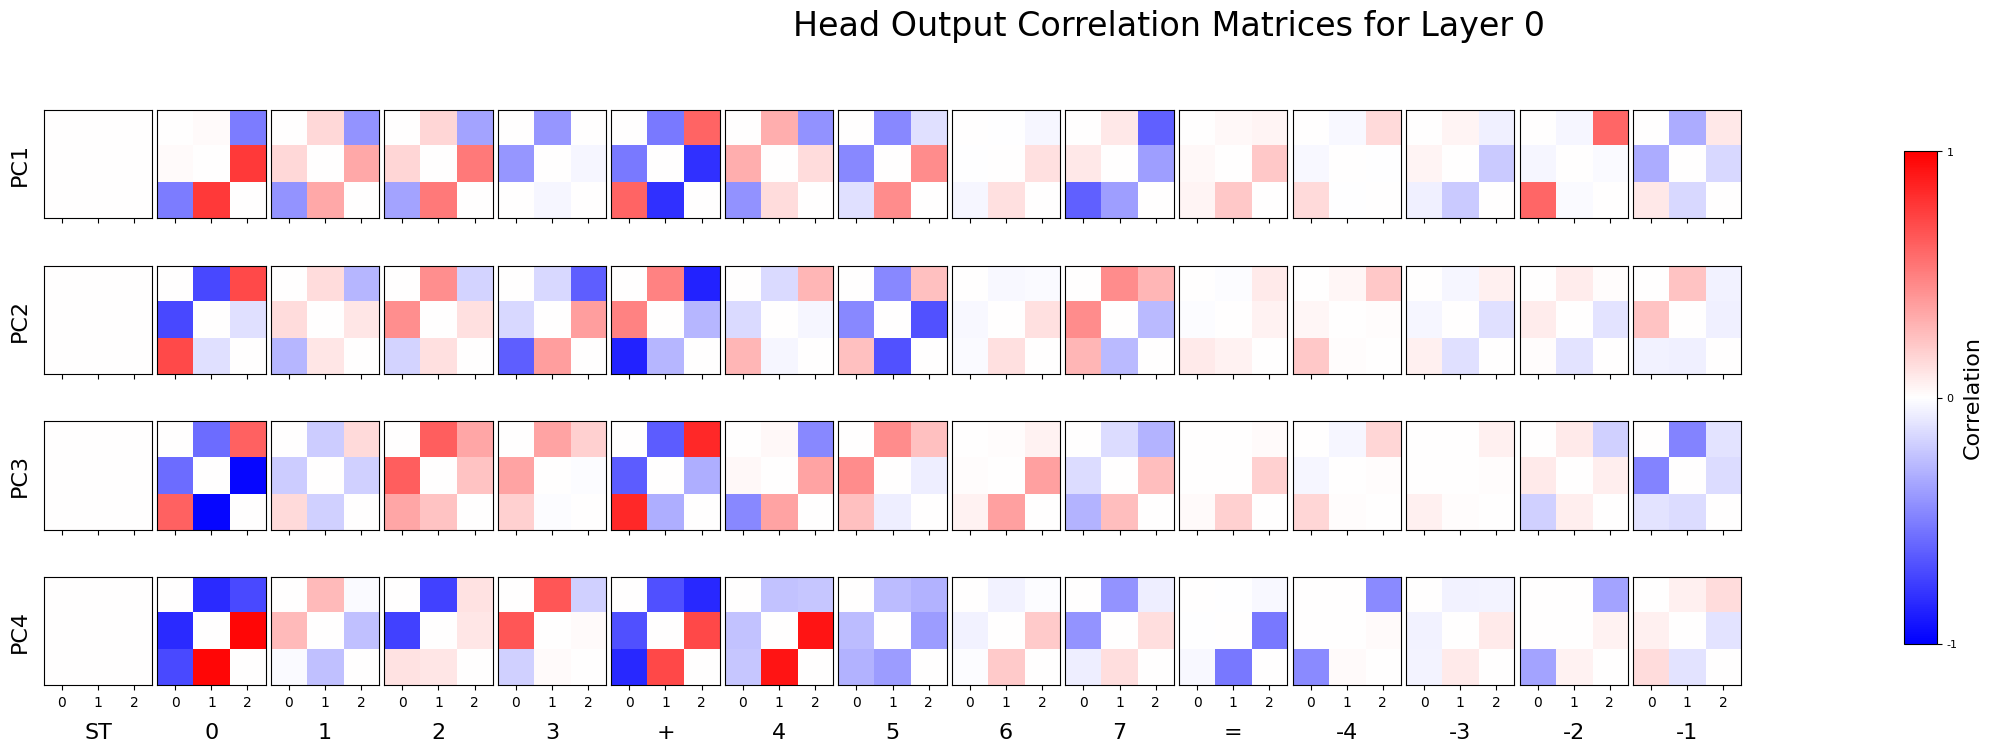

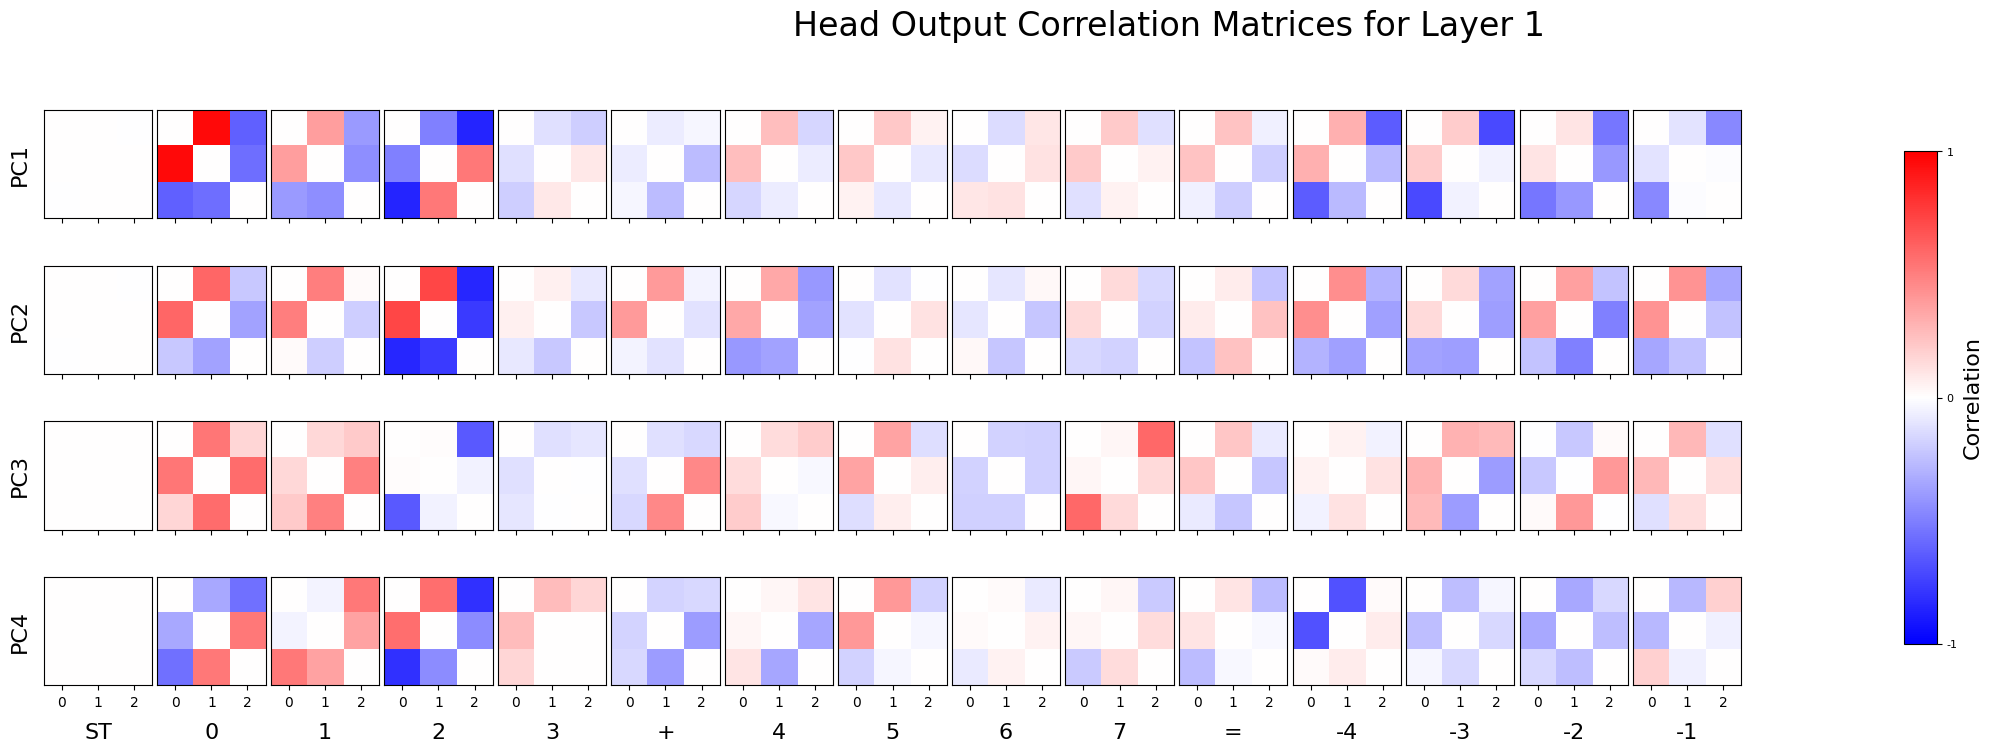

In [19]:
corr_loss = CorrLoss(rank=4)
for layer in range(LAYERS) :
    corr_loss.plot_tensors( cache["result",layer]     , layer=layer, fill_diagonal=False )
#     corr_loss.plot_tensors( cache_corr["result",layer], layer=layer, epoch=0 )

# print(  "error_rate", error_rate( logits, dataset_no_carry, -2) )

#### ** <i>Visulaization code</i> **

In [20]:

from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

def visualize_ablation_digit_heads(ablations, title=None ) :

    digits = [ -5, -3, -2, -4 ]

    def make_array( ablations, digit, layer, head ) :
        ablate = ablations[ (layer,head) ]
        arr = np.zeros((WORDS,WORDS),dtype=float)
        for word in range(WORDS) :
            arr[:,word] = ablate[0][(word,digit)]
        return arr



    fig, axs = plt.subplots(LAYERS,HEADS, figsize=(HEADS*3.5, LAYERS*3.5))
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    if title is not None :
        fig.suptitle(title)



    cmaps = [ 'Reds','Blues','Purples','Greens']
    pos  = [ 0., 0., 0., .25]

    for layer in range(LAYERS):
        for head in range(HEADS):
            arr = []
            for d,digit in enumerate(digits) :
                arr.append(  make_array( ablations, digit, layer, head ) )  

            ax = axs[layer, head] if LAYERS > 1 else axs[head]


            ax.set_title(f'Layer {layer}, Head {head}')

            ax.set_yticks(np.arange(-.5, WORDS-.5,1), minor=True)
            ax.set_yticks(np.arange(WORDS), minor=False)

            if (head==0) :
                ax.set_ylabel('Inputted Words')
                ax.set_yticklabels(LABELS)
            else :
                ax.set_yticklabels([])

            if (layer == LAYERS-1) :
                ax.set_xlabel('\"Result\" words')
                

            ax.set_xticks(np.arange(-.5, WORDS-.5,1), minor=True)
            ax.set_xticks(np.arange(0,WORDS,1), minor=False)
            ax.set_xticklabels(LABELS)
            
            ax.invert_yaxis()

            # Draw horizontal grid lines
            ax.hlines(np.arange(-.5, WORDS-.5,1), *ax.get_xlim(), color='grey', linewidth=1)
            # Draw vertical grid lines
            ax.vlines(np.arange(-.5, WORDS-.5,1), *ax.get_ylim(), color='grey', linewidth=1)

            def offset(d_in,i,j) :
                off = False
                for dd in range(d_in) :
                    if arr[dd][i,j] > 0.005 :
                        off = True
                        break
                return off
            
            cax = ax.imshow(np.zeros((WORDS,WORDS),dtype=float), cmap='Greys',aspect='equal',vmin=0,vmax=1)
            for i in range(arr[d].shape[0]):
                for j in range(arr[d].shape[1]):
                    for d in range(len(digits)) : 
                        cmap = plt.get_cmap(cmaps[d]) 
                        if (arr[d][i,j]>.005) :
                            darkcolor = cmap(1.0)
                            color = cmap(arr[d][i, j])
                            if offset(d,i,j) :
                                rect = Rectangle((j - 0.5 + .35, i - 0.5 + .35), .9, .9, linewidth=2, edgecolor=darkcolor, facecolor=color)
                            else :
                                rect = Rectangle((j - 0.5      , i - 0.5      ), 1.0, 1.0, linewidth=2, edgecolor=darkcolor, facecolor=color)     
                            ax.add_patch(rect)
                    

            # ax.grid(which='minor', color='black',  linewidth=5)

            ax.tick_params(axis='x', which='major', length=0)
            ax.tick_params(axis='y', which='major', length=0)
            ax.tick_params(axis='x', which='minor', length=0)
            ax.tick_params(axis='y', which='minor', length=0)

           
    plt.subplots_adjust(hspace=0.5) 
    plt.show()


## Results of mean ablation runs
 


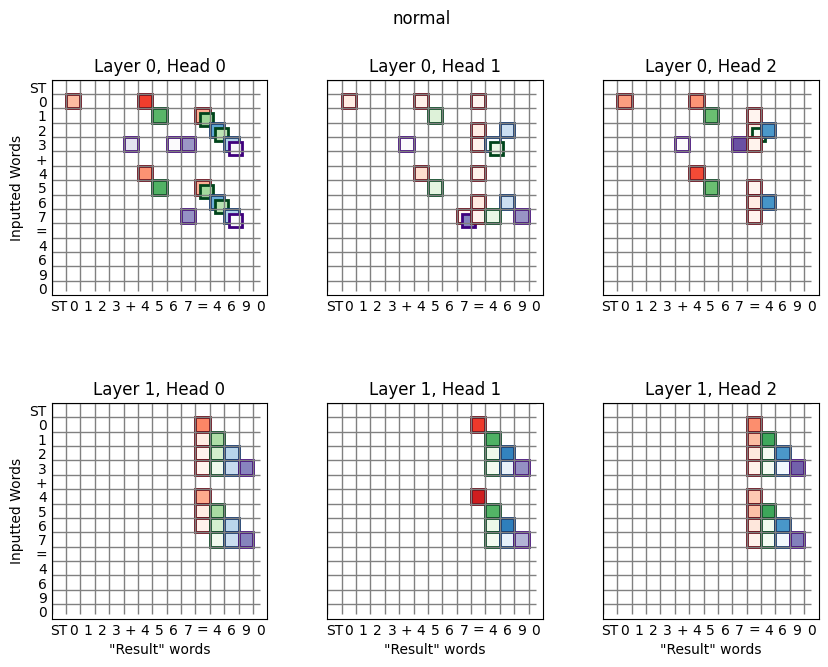

In [21]:

visualize_ablation_digit_heads(ablations     ,title=f"normal")
# visualize_ablation_digit_heads(ablations_corr,title=f"corr_loss")

## This is all Chatgpt generated code below, hallelujah

In [31]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch.nn.functional as F

def logistic_regression(X,y) :
    # Load the Iris dataset
    # iris = load_iris()
    # X = iris.data  # Features: sepal length, sepal width, petal length, petal width
    # print(X.shape)
    # y = iris.target  # Target: species of Iris (setosa, versicolor, virginica)
    # print(y.shape)
    # print(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # It's a good practice to standardize the data (mean=0 and variance=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create the logistic regression model
    log_reg = LogisticRegression(random_state=42, max_iter=200)

    # Fit the model to the training data
    log_reg.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = log_reg.predict(X_test)

    # Output the accuracy of the model
    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

    # Output the confusion matrix
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))

def linear_regression(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # It's a good practice to standardize the data (mean=0 and variance=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create the linear regression model
    lin_reg = LinearRegression()

    # Fit the model to the training data
    lin_reg.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = lin_reg.predict(X_test)

    # Output the Mean Squared Error of the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse:.2f}')

    # Output the R-squared score of the model
    r2 = r2_score(y_test, y_pred)
    print(f'R-squared: {r2:.2f}')

    return lin_reg  # Optional: return the model for further use

import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def pca_the_points(points, n_components=10, graph=True,labels=None):

    n_components=min(n_components,points.size(0))

    pca = PCA(n_components=n_components)
    data = points.detach().cpu().numpy()
    pca_result = pca.fit_transform(data)

    # Get the two components
    comp1 = pca.components_[0]
    comp2 = pca.components_[1]

    # Print the explained variance by each component
    print("Explained variance by component:", np.round(pca.explained_variance_ratio_,2)*100)

    if graph:
        # Plotting the explained variance
        plt.figure(figsize=(8, 5))
        plt.bar(range(n_components), pca.explained_variance_ratio_, align='center')
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")
        plt.title("Explained Variance by Principal Component")
        plt.show()

     # Create a bar chart
        width = 0.4
        indices = np.arange(48)

        plt.figure(figsize=(12, 6))
        bar1 = plt.bar(indices, pca.components_[0], width, color='b', label='Principal Component 1')
        bar2 = plt.bar(indices + width, pca.components_[1], width, color='r', label='Principal Component 2')
        plt.xlabel("Dimensions")
        plt.ylabel("Weight")
        plt.title("Weights of Dimensions for First Two Principal Components")
        plt.xticks(indices + width / 2, indices)  # X-axis labels (centered)
        plt.legend()

        plt.tight_layout()
        plt.show()


        n=points.size(0) # n=pca_result.shape[0] number of points to plot

        xi = 1
        yi = 2


        plt.figure(figsize=(8, 8))
        plt.scatter(pca_result[:n, xi], pca_result[:n, yi], s=50, c='blue', edgecolors='k', marker='o', alpha=0.7)

        if labels is  None :
            for i in range(n) :
                plt.annotate(i, (pca_result[i, xi], pca_result[i, yi]), fontsize=18, ha="right")
        else :
            for i,label in enumerate(labels) :
                plt.annotate( label , (pca_result[i, xi], pca_result[i, yi]), fontsize=18, ha="right")

        # Setting labels and title
        plt.xlabel(f"Principal Component {xi}")
        plt.ylabel(f"Principal Component {yi}")
        # plt.xlim(-.7, .7)  # Set the x-axis limits 
        # plt.ylim(-.7, .7)  # Set the y-axis limits
        plt.title(f"Projection of Vectors on PC {xi} and PC {yi}")
        plt.grid(True)

        plt.show()

    return comp1, comp2

def show_gram_matrix(y, y_pred) :


    y_l2_normalized      = F.normalize(y, p=2, dim=0)
    y_pred_l2_normalized = F.normalize(y_pred, p=2, dim=0)

    gram_matrix = t.mm( y_l2_normalized, y_pred_l2_normalized.t())

    colorscale = [[0, 'white'], [.5, 'white'], [1.0, 'green']]

    fig = go.Figure(data=go.Heatmap(
        z=gram_matrix.detach().cpu().numpy(),
        colorscale=colorscale,
        zmin=-1,
        zmax=1,
        x=list(range(0, gram_matrix.size(-1))),  
        y=list(range(0, gram_matrix.size(-1))),
    ))

    fig.update_layout(
        title='Gram Matrix Predicted vs Actual (correlation)',
        xaxis_title='Actual Embedding position p-1',
        yaxis_title='Predicted Embedding at position p-1',
        yaxis_autorange='reversed', 
        autosize=False,
        height=500,
        width=500,
    )
    print("predicted embedding correlates highest with actual embedding")
    fig.show("png")



#  Some experiments

/Users/alistair/opt/anaconda3/envs/arena/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Accuracy: 1.00
Confusion Matrix:
[[ 80   0   0   0   0   0   0   0   0   0]
 [  0  52   0   0   0   0   0   0   0   0]
 [  0   0  59   0   0   0   0   0   0   0]
 [  0   0   0  61   0   0   0   0   0   0]
 [  0   0   0   0  55   0   0   0   0   0]
 [  0   0   0   0   0  79   0   0   0   0]
 [  0   0   0   0   0   0  85   0   0   0]
 [  0   0   0   0   0   0   0  80   0   0]
 [  0   0   0   0   0   0   0   0  74   0]
 [  0   0   0   0   0   0   0   0   0 175]]
Mean Squared Error: 3.63
R-squared: 0.61
Mean Squared Error: 0.00
R-squared: 1.00
Explained variance by component: [26. 23. 10.  9.  7.  6.  5.  4.  3.  2.]


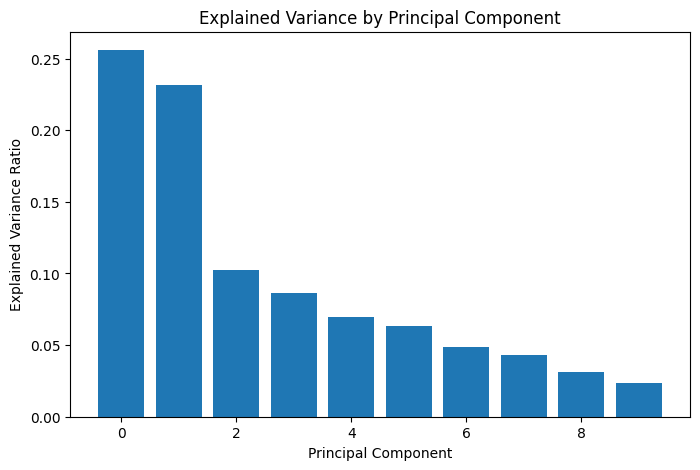

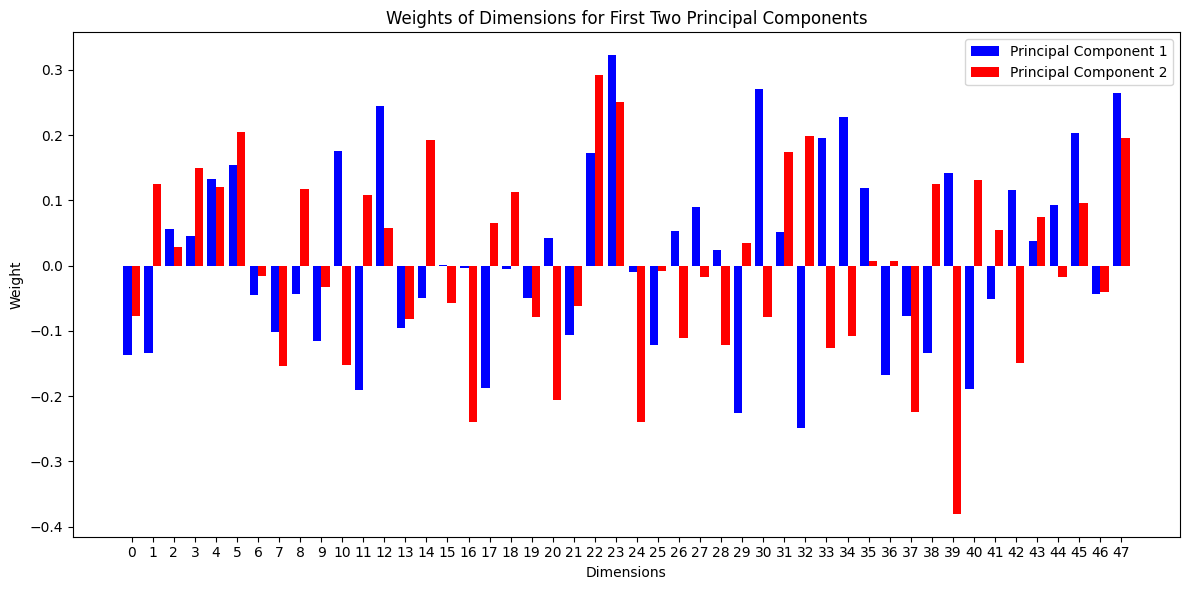

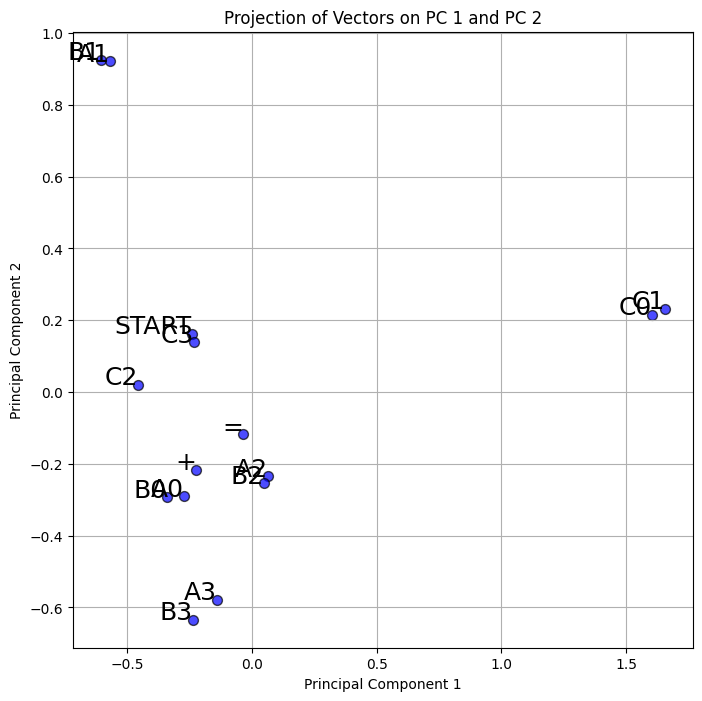

predicted embedding correlates highest with actual embedding


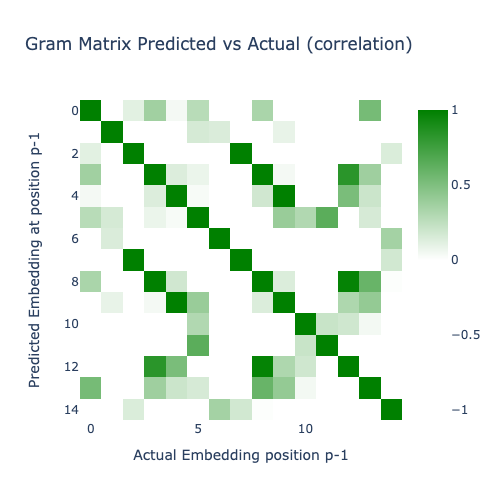

In [32]:

# How are the final activations organized?
# Check to see if they are related by a logistic regression or a linear regression
digits = logits.softmax(dim=-1).argmax(dim=-1)[:,-5:-1].detach().cpu().numpy()
y = digits.reshape( digits.shape[0]*digits.shape[1] )
result = cache["resid_post",1][:,-5:-1,:]
X = result.reshape( result.shape[0]*result.shape[1], result.shape[2] )
logistic_regression(X,y)
linear_regression(X,y)

# How are the initial activations organized?
# Check to see if they are related by a linear regression
result = cache["resid_pre",0][:,-4:,:]
X = result.reshape( result.shape[0]*result.shape[1], result.shape[2] )
linear_regression(X,y)

# Let's look at the position embeddings. Are they organized in a way that makes sense?
pos_e = model.pos_embed(t.tensor( [i for i in range(15)]).unsqueeze(0)).squeeze(0)
# print(pos_e.shape)
pca_the_points(pos_e, n_components=10, graph=True,labels=["START","A0","A1","A2","A3","+","B0","B1","B2","B3","=","C0","C1","C2","C3"])
show_gram_matrix(pos_e, pos_e)



## The 1000s digit. What matters? 

In [24]:
layer = 0
digit = -5
output_digit = digit+1
print(f"Predicting digit {digit}")

y_orig = dataset.p.detach().cpu().numpy()
remap = {}
for i in range(Pairs.p.shape[0]) :
    p = Pairs.p[i]
    if   p[1] == 2 :
        remap[i] = 0
    elif p[1] == 1 and p[2]==2 :
        remap[i] = 1
    elif p[1] == 1 and p[2]==1 and p[3]==2:
        remap[i] = 2
    else :
        remap[i] = 3

seq   = 10
y  = np.array([ remap[y_orig[i]] for i in range(y_orig.shape[0]) ])
X = cache["result",layer][:,seq,:,:].sum(1,keepdim=False).detach().cpu().numpy()
print(f"at word {seq}, Logistic Regression predicts carrying the {digit+1} digit")
logistic_regression(X,y)

seq   = 6
indices = np.where(y==3)
y = dataset.toks.detach().cpu().numpy()[indices][:,output_digit]
X = cache["result",layer][:,seq,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]
print(f"at word {seq},  Logistic Regression predicts the {digit} digit when there is no carrying")
logistic_regression(X,y)



Predicting digit -5
at word 10, Logistic Regression predicts carrying the -4 digit
Accuracy: 0.98
Confusion Matrix:
[[ 67   0   0   0]
 [  0  25   1   0]
 [  0   0   4   1]
 [  0   0   2 100]]
at word 6,  Logistic Regression predicts the -5 digit when there is no carrying
Accuracy: 1.00
Confusion Matrix:
[[ 4  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0  0 14  0]
 [ 0  0  0  0  0  0  0  0 18]]


/Users/alistair/opt/anaconda3/envs/arena/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## The 100s digit. What matters?

In [25]:
layer = 0
digit = -4
output_digit = digit+1
print(f"Predicting digit {digit}")

remap = {}
for i in range(Pairs.p.shape[0]) :
    p = Pairs.p[i]
    if   p[2] == 2 :
        remap[i] = 0
    elif p[2] == 1 and p[3]==2 :
        remap[i] = 1
    else :
        remap[i] = 2

seq   = 11
y_orig = dataset.p.detach().cpu().numpy()
y  = np.array([ remap[y_orig[i]] for i in range(y_orig.shape[0]) ])
X = cache["result",layer][:,seq,:,:].sum(1,keepdim=False).detach().cpu().numpy()
print(f"at word {seq}, Logistic Regression predicts carrying the {digit+1} digit")
logistic_regression(X,y)

seq   = 7
indices = np.where(y==2)
y = dataset.toks.detach().cpu().numpy()[indices][:,output_digit]
print(y.shape)
X = cache["result",layer][:,seq,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]
print(f"at word {seq},  Logistic Regression predicts the {digit} digit when there is no carrying")
logistic_regression(X,y)



Predicting digit -4
at word 11, Logistic Regression predicts carrying the -3 digit
Accuracy: 1.00
Confusion Matrix:
[[ 64   0   0]
 [  0  15   0]
 [  0   0 121]]
(554,)
at word 7,  Logistic Regression predicts the -4 digit when there is no carrying
Accuracy: 0.96
Confusion Matrix:
[[ 6  1  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0 30]]


/Users/alistair/opt/anaconda3/envs/arena/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## The 100s digit. 

In [26]:
layer = 0
digit = -3
output_digit = digit+1
print(f"Predicting digit {digit}")

remap = {}
for i in range(Pairs.p.shape[0]) :
    p = Pairs.p[i]
    if   p[3] == 2 :
        remap[i] = 0
    else :
        remap[i] = 1

seq   = 12
y_orig = dataset.p.detach().cpu().numpy()
y  = np.array([ remap[y_orig[i]] for i in range(y_orig.shape[0]) ])
X = cache["result",layer][:,seq,:,:].sum(1,keepdim=False).detach().cpu().numpy()
logistic_regression(X,y)
print(f"at word {seq}, Logistic Regression predicts carrying the {digit+1} digit")


seq1 = 11
seq2 = -3
indices = np.where(y==1)
y = dataset.toks.detach().cpu().numpy()[indices][:,output_digit]
X1 = cache["result",layer][:,seq1,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]
X2 = cache["result",layer][:,seq2,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]
X  = np.concatenate((X1,X2),axis=1)
print(f"using words {seq1} and {seq2},  Logistic Regression predicts the {digit} digit when there is no carrying")
logistic_regression(X,y)


Predicting digit -3
Accuracy: 1.00
Confusion Matrix:
[[ 76   0]
 [  0 124]]
at word 12, Logistic Regression predicts carrying the -2 digit
using words 11 and -3,  Logistic Regression predicts the -3 digit when there is no carrying
Accuracy: 0.96
Confusion Matrix:
[[ 5  2  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0]
 [ 0  1  8  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  1  8  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  1  0]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 44]]


/Users/alistair/opt/anaconda3/envs/arena/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



## The 10s digit

In [27]:
layer = 0
digit = -2
output_digit = digit+1
print(f"Predicting digit {digit}")

remap = {}
for i in range(Pairs.p.shape[0]) :
    p = Pairs.p[i]
    remap[i] = p[3]
    
seq1 = 9
seq2 = -2
y_orig = dataset.p.detach().cpu().numpy()
yy  = np.array([ remap[y_orig[i]] for i in range(y_orig.shape[0]) ])
indices = np.where(yy < 2)
y = dataset.toks.detach().cpu().numpy()[indices][:,output_digit]
X1 = cache["result",layer][:,seq1,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]
X2 = cache["result",layer][:,seq2,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]
X  = np.concatenate((X1,X2),axis=1)
print(f"using words {seq1} and {seq2},  Logistic Regression predicts the {digit} digit when there is no carrying")
logistic_regression(X,y)


indices = np.where(yy == 2)
y = dataset.toks.detach().cpu().numpy()[indices][:,output_digit]
X1 = cache["result",layer][:,seq1,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]
X2 = cache["result",layer][:,seq2,:,:].sum(1,keepdim=False).detach().cpu().numpy()[indices]
X  = np.concatenate((X1,X2),axis=1)
print(f"using words {seq1} and {seq2},  Logistic Regression predicts the {digit} digit when there is carrying")
logistic_regression(X,y)

Predicting digit -2
using words 9 and -2,  Logistic Regression predicts the -2 digit when there is no carrying
Accuracy: 0.98
Confusion Matrix:
[[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0  5  1  0  0]
 [ 0  0  0  0  0  0  0  8  1  0]
 [ 0  0  0  0  0  0  0  0 14  1]
 [ 0  0  0  0  0  0  0  0  0 71]]
using words 9 and -2,  Logistic Regression predicts the -2 digit when there is carrying
Accuracy: 0.96
Confusion Matrix:
[[16  0  0  0  0  0  0  0  0]
 [ 0 17  1  0  0  0  0  0  0]
 [ 0  1 10  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  1  2  0  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  1]]


/Users/alistair/opt/anaconda3/envs/arena/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/alistair/opt/anaconda3/envs/arena/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

## Code to quickly look at the errors that are generated by the mean ablation runs
- It isn't pretty, but it helped me see some patterns

In [28]:
import math
from scipy import stats

layer = 0
head  = 1
output_word  = 3
input_word   = 12
digit = -3


# print out the significance of the errors if the cases (0,1,2) are generated evenly and randomly (which they are)
def find_driver_of_error( ablations, layer, head, output_word, input_word, digit) :

    ablate = ablations[ (layer,head) ][1][(output_word,digit)]

    if (len(ablate)==0) :
        return
    else :
        ablate = ablate[input_word]
    
    histogram = np.zeros(Pairs.p.shape[0],dtype=int)
    for i in range(len(ablate)) :
        histogram[ablate[i][0].item() ] += 1

    n = np.sum(histogram)

    if (n<20) :
        return
    print( output_word, input_word, n)

    hist_pair = np.zeros( (4,3) , dtype=float )
    for i in range(Pairs.p.shape[0]) :
        for j in range(1,Pairs.p.shape[1]) :
            if histogram[i] > 0 :
                hist_pair[j][ Pairs.p[i][j] ] +=  histogram[i] 

    hist_pair = hist_pair / n
    expected_proportion = 1.0 / 3.0
    hist_max   = np.max( hist_pair, axis=1 )
    hist_index = np.argmax(hist_pair, axis=1)

    for i in range(1,hist_max.shape[0]):
        z_stat = (hist_max[i] - expected_proportion) / math.sqrt((expected_proportion * (1 - expected_proportion)) / n)
        if z_stat > 2.0 : 
            print(f'sensitivity-digit={DIGITS[i]}, value = {hist_index[i]}, z-stat = {z_stat:.2f}')



layer = 0
output_words = [10]
digit  = 0
# for digit in range(len(DIGITS)) :
print("layer", layer)
print("DIGITS", DIGITS[digit])
for head in range(HEADS) :
    print("HEAD", head)
    for output_word in output_words :
        print("output word", output_word)
        for input_word in range(1,WORDS) :
            find_driver_of_error( ablations, layer, head, output_word, input_word, DIGITS[digit] )

layer 0
DIGITS -5
HEAD 0
output word 10
10 2 294
sensitivity-digit=-4, value = 0, z-stat = 2.35
10 7 282
sensitivity-digit=-4, value = 0, z-stat = 3.92
HEAD 1
output word 10
10 3 52
sensitivity-digit=-4, value = 1, z-stat = 9.32
sensitivity-digit=-3, value = 1, z-stat = 2.55
10 6 24
sensitivity-digit=-4, value = 1, z-stat = 5.20
sensitivity-digit=-3, value = 1, z-stat = 4.33
sensitivity-digit=-2, value = 2, z-stat = 3.90
10 8 60
sensitivity-digit=-4, value = 1, z-stat = 10.41
sensitivity-digit=-3, value = 1, z-stat = 6.02
HEAD 2
output word 10
10 3 55
sensitivity-digit=-4, value = 1, z-stat = 10.49
sensitivity-digit=-3, value = 1, z-stat = 3.34
sensitivity-digit=-2, value = 2, z-stat = 2.19
10 8 51
sensitivity-digit=-4, value = 1, z-stat = 10.10
sensitivity-digit=-3, value = 1, z-stat = 4.46
sensitivity-digit=-2, value = 2, z-stat = 2.08
